In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,  OneHotEncoder
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [128]:
df = pd.read_csv('./data/train.csv')
df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [129]:
test_df = pd.read_csv('./data/test.csv')
test_df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


# Análise Exploratória

In [130]:
df.shape

(517754, 14)

In [131]:
test_df.shape

(172585, 13)

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [133]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172585 entries, 0 to 172584
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      172585 non-null  int64  
 1   road_type               172585 non-null  object 
 2   num_lanes               172585 non-null  int64  
 3   curvature               172585 non-null  float64
 4   speed_limit             172585 non-null  int64  
 5   lighting                172585 non-null  object 
 6   weather                 172585 non-null  object 
 7   road_signs_present      172585 non-null  bool   
 8   public_road             172585 non-null  bool   
 9   time_of_day             172585 non-null  object 
 10  holiday                 172585 non-null  bool   
 11  school_season           172585 non-null  bool   
 12  num_reported_accidents  172585 non-null  int64  
dtypes: bool(4), float64(1), int64(4), object(4)
memory usage: 12.5+ MB


In [134]:
df.describe()

,id,num_lanes,curvature,speed_limit,num_reported_accidents,accident_risk
count,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000,517754.000000
mean,258876.500000,2.491511,0.488719,46.112575,1.187970,0.352377
std,149462.849975,1.120434,0.272563,15.788521,0.895961,0.166417
min,0.000000,1.000000,0.000000,25.000000,0.000000,0.000000
25%,129438.250000,1.000000,0.260000,35.000000,1.000000,0.230000
50%,258876.500000,2.000000,0.510000,45.000000,1.000000,0.340000
75%,388314.750000,3.000000,0.710000,60.000000,2.000000,0.460000
max,517753.000000,4.000000,1.000000,70.000000,7.000000,1.000000


accident_risk             1.000000
curvature                 0.543946
speed_limit               0.430898
num_reported_accidents    0.213891
id                        0.000969
num_lanes                -0.006003
Name: accident_risk, dtype: float64


<Axes: >

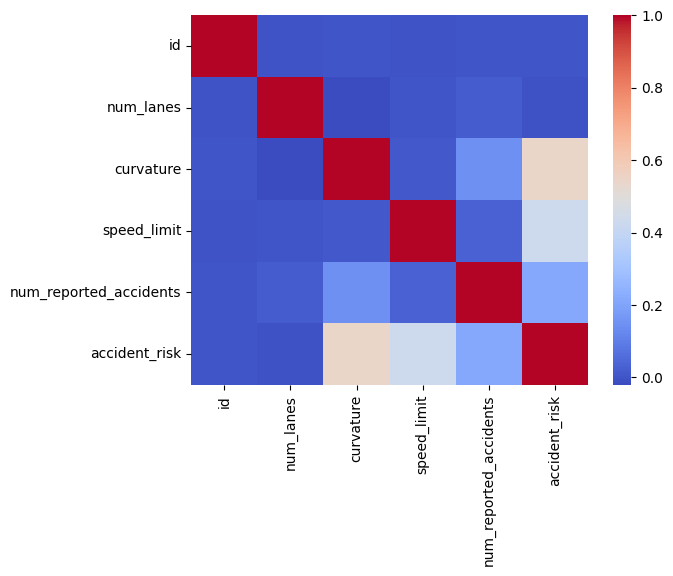

In [135]:
corr = df.select_dtypes(include='number').corr()
corr_target = corr['accident_risk'].sort_values(ascending=False)
print(corr_target)
sns.heatmap(corr, cmap='coolwarm')

In [136]:
df['num_reported_accidents'].value_counts()

num_reported_accidents
1    209674
2    145965
0    125269
3     34197
4      2392
5       231
6        24
7         2
Name: count, dtype: int64

In [137]:
df['accident_risk'].value_counts()

accident_risk
0.34    15542
0.32    14240
0.37    13453
0.28    13287
0.39    12499
        ...  
0.94       47
0.97       28
0.96       28
0.90       26
0.93       23
Name: count, Length: 98, dtype: int64

# Pré-processamento

In [138]:
scaler = MinMaxScaler()
num_features = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']
df[num_features] = scaler.fit_transform(df[num_features])
df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,0.333333,0.06,0.222222,daylight,rainy,False,True,afternoon,False,True,0.142857,0.13
1,1,urban,1.000000,0.99,0.222222,daylight,clear,True,False,evening,True,True,0.000000,0.35
2,2,rural,1.000000,0.63,1.000000,dim,clear,False,True,morning,True,False,0.285714,0.30
3,3,highway,1.000000,0.07,0.222222,dim,rainy,True,True,morning,False,False,0.142857,0.21
4,4,rural,0.000000,0.58,0.777778,daylight,foggy,False,False,evening,True,False,0.142857,0.56


In [139]:
num_features = test_df.select_dtypes(include=['int64', 'float64']).columns
num_features = [c for c in num_features if c != 'id']
scaler = MinMaxScaler()
test_df[num_features] = scaler.fit_transform(test_df[num_features])
test_df.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,0.333333,0.34,0.444444,night,clear,True,True,afternoon,True,True,0.142857
1,517755,urban,0.666667,0.04,0.444444,dim,foggy,True,False,afternoon,True,False,0.000000
2,517756,urban,0.333333,0.59,0.222222,dim,clear,True,False,afternoon,True,True,0.142857
3,517757,rural,1.000000,0.95,0.222222,daylight,rainy,False,False,afternoon,False,False,0.285714
4,517758,highway,0.333333,0.86,0.222222,daylight,clear,True,False,evening,False,True,0.428571


In [140]:
cat_features = ['road_type', 'lighting', 'weather', 'time_of_day']
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

encoded = enc.fit_transform(df[cat_features])

encoded_df = pd.DataFrame(encoded, columns=enc.get_feature_names_out(cat_features))

df = pd.concat([df.drop(columns=cat_features), encoded_df], axis=1)
df.head()

,id,num_lanes,curvature,speed_limit,road_signs_present,public_road,holiday,school_season,num_reported_accidents,accident_risk,...,road_type_urban,lighting_daylight,lighting_dim,lighting_night,weather_clear,weather_foggy,weather_rainy,time_of_day_afternoon,time_of_day_evening,time_of_day_morning
0,0,0.333333,0.06,0.222222,False,True,False,True,0.142857,0.13,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1,1.000000,0.99,0.222222,True,False,True,True,0.000000,0.35,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2,1.000000,0.63,1.000000,False,True,True,False,0.285714,0.30,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,3,1.000000,0.07,0.222222,True,True,False,False,0.142857,0.21,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,4,0.000000,0.58,0.777778,False,False,True,False,0.142857,0.56,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [141]:
cat_features = test_df.select_dtypes(include=['object', 'category']).columns
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

encoded = enc.fit_transform(test_df[cat_features])

encoded_df = pd.DataFrame(encoded, columns=enc.get_feature_names_out(cat_features))

test_df = pd.concat([test_df.drop(columns=cat_features), encoded_df], axis=1)

In [142]:
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)
df.head()

,id,num_lanes,curvature,speed_limit,road_signs_present,public_road,holiday,school_season,num_reported_accidents,accident_risk,...,road_type_urban,lighting_daylight,lighting_dim,lighting_night,weather_clear,weather_foggy,weather_rainy,time_of_day_afternoon,time_of_day_evening,time_of_day_morning
0,0,0.333333,0.06,0.222222,0,1,0,1,0.142857,0.13,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1,1.000000,0.99,0.222222,1,0,1,1,0.000000,0.35,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,2,1.000000,0.63,1.000000,0,1,1,0,0.285714,0.30,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,3,1.000000,0.07,0.222222,1,1,0,0,0.142857,0.21,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,4,0.000000,0.58,0.777778,0,0,1,0,0.142857,0.56,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [143]:
bool_cols = test_df.select_dtypes(include='bool').columns
test_df[bool_cols] = test_df[bool_cols].astype(int)
test_df.head()

,id,num_lanes,curvature,speed_limit,road_signs_present,public_road,holiday,school_season,num_reported_accidents,road_type_highway,...,road_type_urban,lighting_daylight,lighting_dim,lighting_night,weather_clear,weather_foggy,weather_rainy,time_of_day_afternoon,time_of_day_evening,time_of_day_morning
0,517754,0.333333,0.34,0.444444,1,1,1,1,0.142857,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,517755,0.666667,0.04,0.444444,1,0,1,0,0.000000,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,517756,0.333333,0.59,0.222222,1,0,1,1,0.142857,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,517757,1.000000,0.95,0.222222,0,0,0,0,0.285714,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,517758,0.333333,0.86,0.222222,1,0,0,1,0.428571,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# MLP

In [144]:
Y = df['accident_risk']
X = df.drop(columns=['accident_risk', 'id'])
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=42)

In [145]:
X_train_t = torch.tensor(np.asarray(X_train), dtype=torch.float32)
y_train_t = torch.tensor(np.asarray(Y_train).reshape(-1, 1), dtype=torch.float32)
X_val_t   = torch.tensor(np.asarray(X_val), dtype=torch.float32)
y_val_t   = torch.tensor(np.asarray(Y_val).reshape(-1, 1), dtype=torch.float32)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64)

In [146]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [147]:
mlp = MLP(input_dim=X_train.shape[1])

loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(mlp.parameters(), lr=0.001, momentum=0.9)

In [148]:
train_losses, val_losses = [], []

max_epochs = 500
patience = 15        
min_delta = 1e-3     

best_val_loss = float("inf")
epochs_no_improve = 0
best_state_dict = None
warmup_epochs = 10

for epoch in range(max_epochs):
    mlp.train()
    train_epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = mlp(xb)
        loss = loss_function(preds, yb)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
    train_losses.append(train_epoch_loss / len(train_loader))

    mlp.eval()
    val_epoch_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = mlp(xb)
            loss = loss_function(preds, yb)
            val_epoch_loss += loss.item()
    val_losses.append(val_epoch_loss / len(val_loader))

    cur_val = val_losses[-1]
    improved = False

    if epoch > warmup_epochs:
        if cur_val < best_val_loss - min_delta:
            best_val_loss = cur_val
            best_state_dict = mlp.state_dict().copy()
            epochs_no_improve = 0
            improved = True
        else:
            epochs_no_improve += 1

    print(f"Epoch {epoch+1}/{max_epochs} | Train Loss: {train_losses[-1]:.6f} | Val Loss: {cur_val:.6f} | improved: {improved} | patience: {epochs_no_improve}/{patience}")

    if epochs_no_improve >= patience:
        print(f"Early stopping: sem melhora por {patience} épocas. Melhor val_loss = {best_val_loss:.6f}")
        break

if best_state_dict is not None:
    mlp.load_state_dict(best_state_dict)
    print("Melhor modelo restaurado ao final do treinamento.")
else:
    print("Nenhuma melhora observada — mantendo último estado do modelo.")


Epoch 1/500 | Train Loss: 0.017882 | Val Loss: 0.007028 | improved: False | patience: 0/15
Epoch 2/500 | Train Loss: 0.009514 | Val Loss: 0.006105 | improved: False | patience: 0/15
Epoch 3/500 | Train Loss: 0.008581 | Val Loss: 0.005838 | improved: False | patience: 0/15
Epoch 4/500 | Train Loss: 0.008129 | Val Loss: 0.005739 | improved: False | patience: 0/15
Epoch 5/500 | Train Loss: 0.007876 | Val Loss: 0.005514 | improved: False | patience: 0/15
Epoch 6/500 | Train Loss: 0.007717 | Val Loss: 0.005481 | improved: False | patience: 0/15
Epoch 7/500 | Train Loss: 0.007577 | Val Loss: 0.005495 | improved: False | patience: 0/15
Epoch 8/500 | Train Loss: 0.007461 | Val Loss: 0.005508 | improved: False | patience: 0/15
Epoch 9/500 | Train Loss: 0.007386 | Val Loss: 0.005480 | improved: False | patience: 0/15
Epoch 10/500 | Train Loss: 0.007296 | Val Loss: 0.005399 | improved: False | patience: 0/15
Epoch 11/500 | Train Loss: 0.007254 | Val Loss: 0.005411 | improved: False | patience: 0/

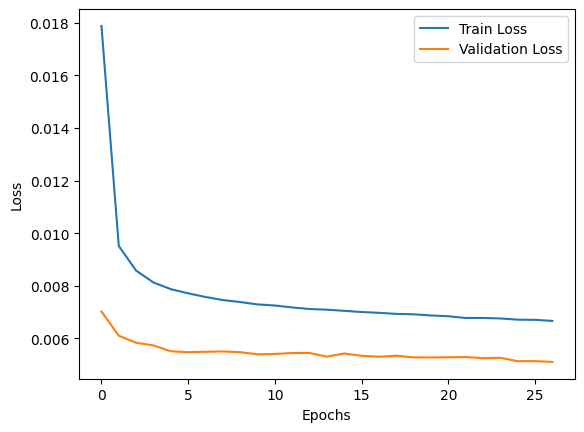

In [149]:

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

MSE:  0.005110
RMSE: 0.071481
MAE:  0.056529
R2:   0.814932
Pearson r: 0.9038 (p=0)


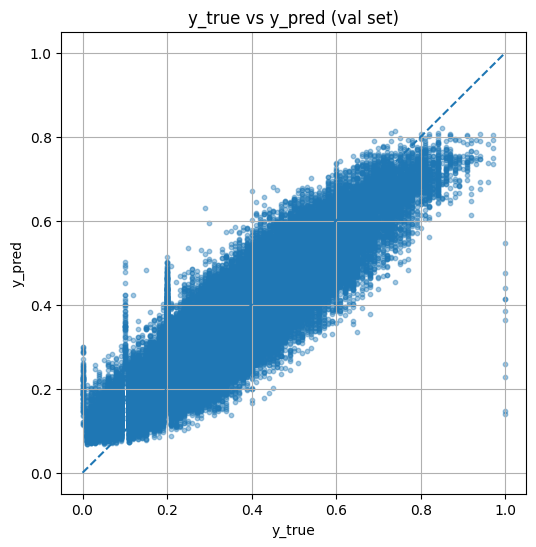

In [150]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

mlp.cpu()
mlp.eval()

preds_list = []
with torch.no_grad():
    for xb, _ in val_loader:
        out = mlp(xb)                   # tensor (B,1) ou (B,)
        preds_list.append(out.squeeze().cpu().numpy())

preds = np.concatenate(preds_list, axis=0).ravel()

if hasattr(Y_val, "values"):
    y_true = Y_val.values.ravel().astype(float)
else:
    y_true = np.array(Y_val).ravel().astype(float)

mse = mean_squared_error(y_true, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, preds)
r2 = r2_score(y_true, preds)

try:
    corr, pval = pearsonr(y_true, preds)
except Exception as e:
    corr, pval = np.nan, np.nan

print(f"MSE:  {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAE:  {mae:.6f}")
print(f"R2:   {r2:.6f}")
print(f"Pearson r: {corr:.4f} (p={pval:.3g})")

plt.figure(figsize=(6,6))
plt.scatter(y_true, preds, alpha=0.4, s=10)
mn = min(y_true.min(), preds.min())
mx = max(y_true.max(), preds.max())
plt.plot([mn,mx],[mn,mx], linestyle='--')  # linha y=x
plt.xlabel("y_true")
plt.ylabel("y_pred")
plt.title("y_true vs y_pred (val set)")
plt.grid(True)
plt.show()


In [151]:
import numpy as np
import torch
import pandas as pd

mlp.cpu()
mlp.eval()

if 'id' in test_df.columns:
    ids = test_df['id']
    X_test = test_df.drop(columns=['id'])
else:
    ids = np.arange(len(test_df))
    X_test = test_df.copy()

X_test_t = torch.tensor(np.asarray(X_test), dtype=torch.float32)

with torch.no_grad():
    out = mlp(X_test_t)
    preds = out.squeeze().cpu().numpy()

submission = pd.DataFrame({
    'id': ids,
    'accident_risk': preds
})

submission.to_csv('submission.csv', index=False)
print("Arquivo 'submission.csv' gerado com sucesso!")


Arquivo 'submission.csv' gerado com sucesso!
